# Micro- (and hopefully soon geo-) Founded Occupational Mobility Network

*Setup from @rmaria del rio-chanona et al. 2021*
*Code: @ebbamark


In [1]:
# Import packages
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
import math as math
from IPython import display
rng = np.random.default_rng()

path = "~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/"

## Setup

### Data

Toy model constructed on 5 fake occupations with pre-determined employment, unemployment, vacancies, target demand, and wages.

In [2]:
# Import information about relevant files to employment/unemployment, target demand, vacancies, etc.
# Initialise with 6 geographies that have same characteristics as in toy model
# geo = pd.read_csv(path+"data/geog_matrix.csv", delimiter=';', header=None)

A1 = pd.read_csv(path+"data/small_adj_full.csv", delimiter=';', decimal=',', header=None)
employment = pd.read_csv(path+"data/employed.csv", header = None)
unemployment = pd.read_csv(path+"data/unemployed.csv", header = None)
vacancies = pd.read_csv(path+"data/vacancies.csv", header = None)
demand_target = pd.read_csv(path+"data/target_demand.csv")
wages = pd.DataFrame(np.round(np.random.normal(50000, 10000, 5)), columns = ['Wages'])


### Agents and Classes

One function and three classes are defined:
- (Function) Utility/decision-making function used by workers when deciding which vacancies to apply to.
- (Class) Worker: individual worker has state-specific attributes (whether or not employed, current or latest held occupation, time employed or unemployed, current or latest wage held, whether or not they have been hired in a particular time step) and character-specific attributes (occupational history, risk aversion score (not yet implemented) and an impatience score (not yet used)). Worker has one function which is to search and apply for a vacancy.
- (Class) Occupation has an id, list of workers currently employed in that occupation, list of neighboring occupations based on transition adjacency matrix (imperfect solution), current and target demand for labour, list of applicants to open vacancies, and wage). Occupation has two internal functions (1) to separate workers and (2) to update all workers in an occupation after each time step.
- (Class) Vacancy has an occupational id, list of applicants (duplicated above in occupation class...to fix), and a wage (duplicated above in occupation class...to fix). Vacancy has one internal function to hire an applicant.

In [3]:
## Defining functions
# Ranking utility/decision-making function
def util(w_current, w_offered, impatience_factor, skill_sim):
    return 1/(1+(math.exp(-impatience_factor*((w_offered-(w_current*(1-skill_sim)))/10000))))

## Defining classes
# Potentially redundant use of IDs in the below classes...to check
class worker:
    def __init__(wrkr, occupation_id, employed, longterm_unemp, time_employed,
                 time_unemployed, wage, hired, list_of_occs, risk_av_score, impatience_score):
        # State-specific attributes:
        # Occ-id
        wrkr.occupation_id = occupation_id
        # Binary variable for whether employed or not
        wrkr.employed = employed
        # Binary variable for whether long-term unemployed
        wrkr.longterm_unemp = longterm_unemp
        # Number of time steps employed
        wrkr.time_employed = time_employed
        # Used as criteria for impatience
        wrkr.time_unemployed = time_unemployed
        # Used as criteria for impatience
        wrkr.wage = wage
        # Used as protective attribute in hiring process (ie. cannot be hired twice)
        wrkr.hired = hired
        
        # Character-specific attributes:
        # Employment history, list of occupations previously held
        # NOT YET USED
        wrkr.emp_history = list_of_occs
        # Identity score - to be defined...
        # wrkr.identity = identity_score
        # Risk aversion: Stefi suggested to use number of 
        # occupations previously held as proxy ie. len(emp_history)
        # NOT YET USED
        wrkr.risk_aversion = risk_av_score
        # Impatience - to be defined. One option will be to make this 
        # a function of time spent unemployed and previous wage
        # NOT YET USED
        wrkr.impatience = impatience_score
    
    def search_and_apply(wrkr, vac_list):
        # A sample of relevant vacancies are found that are in neighboring occupations
        # Will need to add a qualifier in case sample is greater than available relevant vacancies
        rel_vacs = random.sample([vac for vac in vacs if net[wrkr.occupation_id].list_of_neigh_bool[vac.occupation_id]], 20)
        # Sort found relevant vacancies by utility-function defined above and apply to top 5
        # - this latter decision can be modified later to proxy search effort
        for v in sorted(rel_vacs, key = lambda v: v.wage, reverse = True)[slice(5)]:
        # Introduce randomness here...binomial?
            if util(wrkr.wage, v.wage, wrkr.time_unemployed, net[wrkr.occupation_id].list_of_neigh_weights[v.occupation_id]) > 0.5:
                v.applicants.append(wrkr)
        
class occupation:
    def __init__(occ, occupation_id, list_of_workers, list_of_neigh_bool, 
                 list_of_neigh_weights, current_demand, 
                 target_demand, applicants, wage):
        occ.occupation_id = occupation_id
        occ.list_of_workers = list_of_workers
        occ.list_of_neigh_bool = list_of_neigh_bool
        occ.list_of_neigh_weights = list_of_neigh_weights
        occ.current_demand = current_demand
        occ.target_demand = target_demand
        occ.applicants = applicants
        occ.wage = wage
    
    def separate_workers(occ):
        if(len(occ.list_of_workers) != 0):
            sep_prob = delta_u + gamma * max(0, occ.current_demand - occ.target_demand)/sum(wrkr.employed for wrkr in occ.list_of_workers)
            emp = [el for el in occ.list_of_workers if el.employed]
            sep_counter = 0
            for w in random.sample(emp, np.random.binomial(len(emp), sep_prob)):
                w.employed = False
                w.longterm_unemp = False
                w.time_employed = 0
                w.time_unemployed = 0
                sep_counter += 1
    
    def update_workers(occ):
        for w in occ.list_of_workers:
            # Must update hired attribute of workers
            #w.hired = False
            if w.employed:
                w.time_employed += 1
            if not(w.employed):
                w.time_unemployed += 1
                w.longterm_unemp = True if w.time_unemployed >= 7 else False
                
        
class vac:
    def __init__(v, occupation_id, applicants, wage):
        v.occupation_id = occupation_id
        v.applicants = applicants
        v.wage = wage
    # In final looping, this should be conditional on list of applicants
    def hire(v):
        a = random.choice([app for app in v.applicants if not(app.hired)])
        assert(not(a.employed))
        assert(not(a.hired))
        net[v.occupation_id].list_of_workers.append(net[a.occupation_id].list_of_workers.pop(net[a.occupation_id].list_of_workers.index(a)))
        a.occupation_id = v.occupation_id
        a.employed = True
        a.longterm_unemp = False
        a.time_employed = 0
        a.time_unemployed = 0
        a.wage = v.wage
        a.emp_history.append(v.occupation_id)
        a.hired = True
        # Reset?
        # wrkr.risk_aversion = risk_av_score
        # Reset?
        # wrkr.impatience = impatience_score
        v.applicants.clear()
            

### Initialise Network

In [4]:
### Function and condition to initialise network

def initialise(n_occ, employment, unemployment, vacancies, demand_target, A, wages):
    """ Makes a list of occupations with initial conditions
       Args:
           n_occ: number of occupations initialised
           # n_regions: number of regions initialised
           employment: vector with employment of each occupation
           unemployment: vector with unemployment of each occupation
           vacancies: vector with vacancies of each occupation
           demand_target: vector with (initial) target_demand for each occupation (never updated)
           A: adjacency matrix of network (not including auto-transition probability)
           wages: vector of wages of each occupation

       Returns:
            occupations: list of occupations with above attributes
       """
    occs = []
    vac_list = []
    ids = 0
    for i in range(0, n_occ):
        # appending relevant number of vacancies to economy-wide vacancy list
        for v in range(round(vacancies.iat[i,0])):
            vac_list.append(vac(i, [], wages.iat[i,0]))
            
        occ = occupation(i, [], A[i] > 0, A[i],
                         (employment.iat[i,0] + vacancies.iat[i,0]), 
                         demand_target.iat[i,0], [], wages.iat[i,0])
        # creating the workers of occupation i and attaching to occupation
        ## adding employed workers
        for e in range(round(employment.iat[i,0])):
            # Assume they have all at least 1 t.s. of employment
            occ.list_of_workers.append(worker(occ.occupation_id, True, False, 1, 0, wages.iat[i,0], False, [occ.occupation_id], 1, .1))
            ## adding unemployed workers
            # Could consider adding random initial unemployment durations...for now no one becomes longterm unemployed until 6 time steps in
        for u in range(round(unemployment.iat[i,0])):
            # Assigns time unemployed from absolute value of normal distribution....
            occ.list_of_workers.append(worker(occ.occupation_id, False, False, 0, abs(int(np.random.normal(0, 2))), wages.iat[i,0], False,
                                                     [occ.occupation_id], 
                                                      1, .1))
        occs.append(occ)
        ids += 1
    return occs, vac_list
    

In [5]:
###################################
# INITIAL MODEL CONDITIONS ########
###################################

T = 50
delta_u = 0.02
delta_v = 0.02
gamma_u = gamma_v = gamma = 0.03

# Initialise occupational mobility network
net, vacs = initialise(len(A1), employment, unemployment, vacancies, demand_target, A1, wages)


In [6]:
####################
# Testing Cell #####
####################

## Model Run

In [7]:
####################
# RUN MODEL ########
####################

# Records variables of interest
record = pd.DataFrame(columns=['Time', 'Occupation_ID', 'Workers', 'Employment', 'Unemployment', 'Vacancies', 'LT_Unemployed', 'Target_Demand'])

for t in range(T):
    # Ensure number of workers in economy has not changed
    assert(sum(map(lambda x: len(x.list_of_workers), net)) == employment.sum().item() + unemployment.sum().item())
    # print(sum(map(lambda x: len([w for w in x.list_of_workers if w.hired]), net)))
    for occ in net:
        ### SEPARATIONS
        occ.separate_workers()
        
        # Testing
        if t > 0:
            temp = record.loc[(record['Occupation_ID'] == occ.occupation_id) & (record['Time'] == t-1)]
            assert(temp.Employment.item() - sum(wrkr.employed for wrkr in occ.list_of_workers) ==
                   sum(not(wrkr.employed) for wrkr in occ.list_of_workers) - temp.Unemployment.item())
            assert(len(occ.list_of_workers) == temp.Workers.item())
      
        ### APPLICATIONS
        # Questions to verify:
        # - CANNOT be fired and apply in same time step ie. time_unemployed > 0
        # - CAN be rejected and apply in the same time step - no protected attribute
        unemp = [el for el in occ.list_of_workers if not(el.employed) and el.time_unemployed > 0]
        for u in unemp:
            u.search_and_apply(vacs)

        # Update all workers
        occ.update_workers()
        
    ### HIRING
    # Ordering of hiring randomised to ensure list order does not matter in filling vacancies...
    # ....might be better to do this using an unordered set?
    
    for v_open in sorted(vacs,key=lambda _: random.random()):
        if len([app for app in v_open.applicants if not(app.hired)]) > 0:
            v_open.hire()
            vacs.remove(v_open)
            assert(len(v_open.applicants) == 0)
        else:
            pass
    
    ### VACANCIES
    # Update vacancies after all shifts have taken place
    # Could consider making this a function of the class itself
    for occ in net:
        emp = sum(wrkr.employed for wrkr in occ.list_of_workers)
        occ.current_demand = len([v_open for v_open in vacs if v_open.occupation_id == occ.occupation_id]) + emp
        vac_prob = delta_v + ((1 - delta_v) * (gamma * max(0, occ.target_demand - occ.current_demand))) / emp
        for v in range(int(np.random.binomial(emp, vac_prob))):
            vacs.append(vac(occ.occupation_id, [], occ.wage))
        # Record of indicators of interest (occ, # workers, employed, unemployed, vacancies, long_term_unemployed)
        record.loc[len(record)]= [t,
                                  occ.occupation_id,
                                  len(occ.list_of_workers),
                                  sum(wrkr.employed for wrkr in occ.list_of_workers),
                                  sum(not(wrkr.employed) for wrkr in occ.list_of_workers),
                                  len([v_open for v_open in vacs if v_open.occupation_id == occ.occupation_id]),
                                  sum(wrkr.longterm_unemp for wrkr in occ.list_of_workers),
                                  occ.target_demand]
    #print(record.loc[(record['Time'] == t)][['Occupation_ID','Employment','Vacancies', 'Target_Demand']])

print("Done after ", t + 1, " time steps.")

Done after  50  time steps.


## Results

In [8]:
# Results specifications (whether to save as final or not)
final = False
figpath = "~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/output"

#### Overall Economy: Employment, Unemployment, Worker, Vacancy, and Longterm Employed Levels

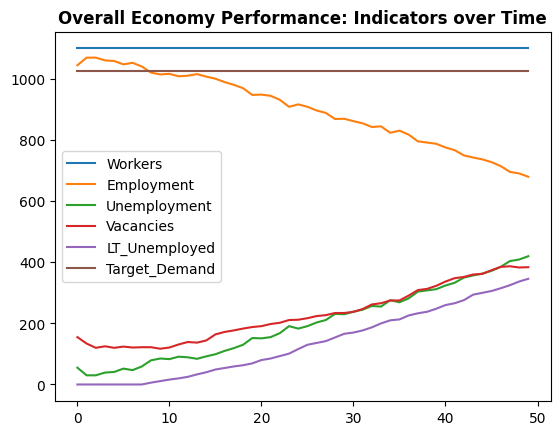

In [9]:
# Indicators in overall economy
totals = record.loc[:,['Time', 'Workers','Employment', 'Unemployment', 'Vacancies', 'LT_Unemployed', 'Target_Demand']].groupby(['Time']).sum()
lgd = []
for column in totals[1:]:
    plt.plot(totals[column])
    lgd.append(column)
plt.title("Overall Economy Performance: Indicators over Time", fontweight = 'bold')
plt.legend(list(lgd), loc="center left", ncol=1)
if final:
    plt.savefig(figpath+'overall_economy.jpg', dpi = 300)
else:
    plt.show()
plt.close()

#### Long-term unemployment rate and levels

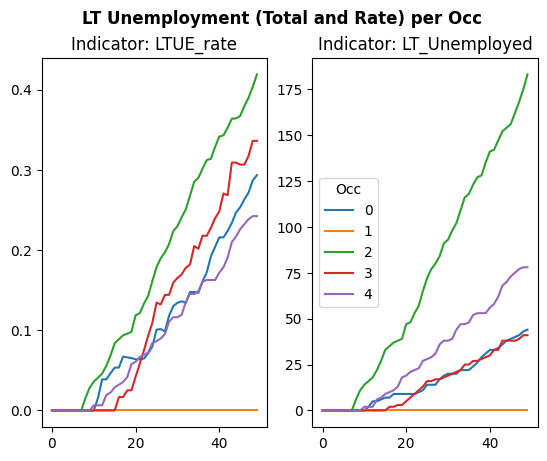

In [10]:
# LT Unemployed per occupation

fig = plt.figure(constrained_layout = False)
ltue = record.loc[:,['Time', 'Occupation_ID','Workers', 'LT_Unemployed']].groupby(['Time', 'Occupation_ID']).sum().reset_index()
ltue['LTUE_rate'] = ltue['LT_Unemployed'] / ltue['Workers']
lgd = []
for i, ind in enumerate(['LTUE_rate', 'LT_Unemployed']):
    fig.add_subplot(1, 2, i+1, title=f'Indicator: {ind}')
    for g in np.unique(ltue.Occupation_ID):
        temp = ltue[(ltue['Occupation_ID'] == g)][[ind, 'Time']]
        plt.plot(temp['Time'], temp[ind])
        lgd.append(int(g))
plt.suptitle("LT Unemployment (Total and Rate) per Occ", fontweight = 'bold')
plt.legend(list(lgd), loc="center left", ncol=1, title = "Occ")
if final:
    plt.savefig(figpath+'ltuer_occ.jpg', dpi = 300)
else:
    plt.show()
plt.close(fig)

#### Occupations: Employment, Unemployment, Worker, Vacancy, and Longterm Employed Levels

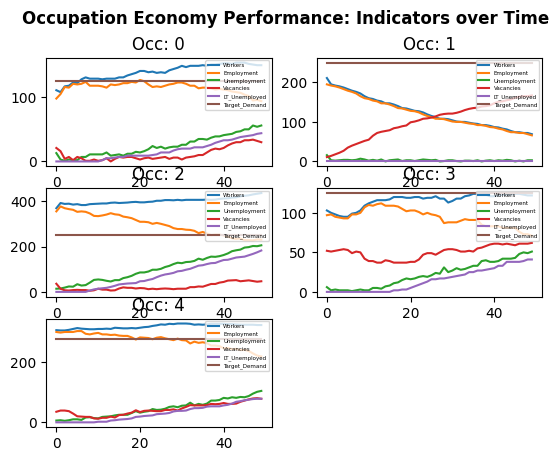

In [11]:
# Overall indicators per occupation
ids = np.unique(record.Occupation_ID)
fig = plt.figure(constrained_layout = False)

occ_totals = record.loc[:,['Time', 'Occupation_ID', 'Workers','Employment', 'Unemployment', 'Vacancies', 'LT_Unemployed', 'Target_Demand']]
for occ in ids:
    gtmp = occ_totals[(occ_totals['Occupation_ID'] == occ)].loc[:, ['Time', 'Workers', 'Employment', 'Unemployment', 'Vacancies', 'LT_Unemployed', 'Target_Demand']].groupby(['Time']).sum()
    # Indicators (workers, employment, etc)
    fig.add_subplot(3, 2, int(occ)+1, title = f'Occ: {int(occ)}')
    lgd = []
    for column in gtmp[1:]:
        plt.plot(gtmp[column])
        lgd.append(column)
    plt.legend(list(lgd), loc='upper right', ncols = 1, title_fontsize = "6", fontsize="4")
fig.suptitle("Occupation Economy Performance: Indicators over Time", fontweight = 'bold')
if final:
    plt.savefig(figpath+'occ_perf.jpg', dpi = 300)
else:
    plt.show()
plt.close(fig)